# Model Predictive Control

In [1]:
import os
import time
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
import matplotlib.pyplot as plt
from casadi import (
    MX, DM, Function, Opti, integrator,
    vec, vcat, vertcat, horzcat, 
    sum1, sum2, sumsqr, sin, cos,
    gradient, jacobian, hessian
)

import casadi
casadi.__version__

'3.6.5'

In [2]:
import matplotlib
matplotlib.__version__

'3.8.0'

In [3]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

## Cart-pole System

Inverted pendulum on a horizontally-constrained cart:

<img src='images/cart_pend_diagram.png' width=300>

The system is controlled by a force acting in the x-direction on the cart. The system is described by a four-dimensional state-space:

$$ x = \left[\begin{matrix} p \\ \theta \\ \dot{p} \\ \dot{\theta} \end{matrix}\right]$$

In [4]:
# Physical constants
g = 9.81     # gravitation [m/s^2]
L = 0.2      # pendulum length [m]
m = 1        # pendulum mass [kg]
mcart = 0.5  # cart mass [kg]

T = 2.0  # control horizon [s]
N = 160  # Number of control intervals
dt = T/N  # length of 1 control interval [s]

# System is composed of 4 states
nx = 4

In [5]:
# CasADi function for the ODE right-hand side
xk = MX.sym('x',nx) # states: pos [m], theta [rad], dpos [m/s], dtheta [rad/s]
uk = MX.sym('u') # control force [N]
ddpos = (
    (uk + m * L * xk[3] * xk[3] * sin(xk[1]) - m * g * sin(xk[1]) * cos(xk[1]))
    / (mcart + m - m * cos(xk[1]) * cos(xk[1]))
)
rhs = vertcat(xk[2], xk[3], ddpos, g/L * sin(xk[1]) - cos(xk[1]) * ddpos)

# Continuous-time system dynamics
f = Function('f', [xk, uk], [rhs], ['xk', 'uk'], ['dxdt'])
f

Function(f:(xk[4],uk)->(dxdt[4]) MXFunction)

In [6]:
# Discrete-time system dynamics
intg_options = {'number_of_finite_elements': 1}

# Reference Runge-Kutta implementation
solver = 'rk'
dae = {'x': xk, 'p': uk, 'ode': f(xk, uk)}
t0 = 0
tf = dt / intg_options['number_of_finite_elements']
intg = integrator('intg', solver, dae, t0, tf, intg_options)
print(intg)
res = intg(x0=xk, p=uk)
xf = res['xf']

# Discretized system dynamics
F = Function('F', [xk, uk], [xf], ['xk', 'uk'], ['xkp1'])
F

intg:(x0[4],z0[0],p,u[0],adj_xf[],adj_zf[],adj_qf[])->(xf[4],zf[0],qf[0],adj_x0[],adj_z0[],adj_p[],adj_u[]) RungeKutta


Function(F:(xk[4],uk)->(xkp1[4]) MXFunction)

## Reference optimal control using multiple shooting

Optimal control problem using multiple shooting

$$
\DeclareMathOperator * {\minimize}{minimize}
\begin{aligned}
\minimize_{x_1,x_2,...,x_{N+1},u_1,u_2,...,u_N} \quad & \sum_{k=1}^{N}{u_k^2} \\
\text{subject to} \quad & F(x_k,u_k) = x_{k+1}, \quad k=1, ..., N \\
                  & -3 \le x_k \le 3, \quad k=1, ..., N+1 \\
                  & -1.2 \le u_k \le 1.2, \quad k=1, ..., N \\
                  & x_1 = \left[\begin{matrix}1 & 0 & 0 & 0\end{matrix}\right]^T \\
                  & x_{N+1} = \left[\begin{matrix}0 & 0 & 0 & 0\end{matrix}\right]^T \\
\end{aligned}
$$

In [7]:
opti = casadi.Opti()

# Decision variables for states
X = opti.variable(nx, N+1)

# Aliases for states
pos    = X[0, :]
theta  = X[1, :]
dpos   = X[2, :]
dtheta = X[3, :]

# Decision variables for control vector
U = opti.variable(N, 1)  # force [N]

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:,k],U[k]))

# Path constraints
opti.subject_to(opti.bounded(-3,  pos, 3)) # Syntax -3 <= pos <= 3 not supported in Python
opti.subject_to(opti.bounded(-1.2, U, 1.2))

# Initial and terminal constraints
opti.subject_to(X[:, 0] == vertcat(1, 0, 0, 0))
opti.subject_to(X[:, -1] == vertcat(0, 0, 0, 0))

# Objective: regularization of controls
opti.minimize(sumsqr(U))

# solve optimization problem
opti.solver('ipopt')

sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3048
Number of nonzeros in inequality constraint Jacobian.:      321
Number of nonzeros in Lagrangian Hessian.............:      960

Total number of variables............................:      804
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      648
Total number of inequality c

## Plot functions

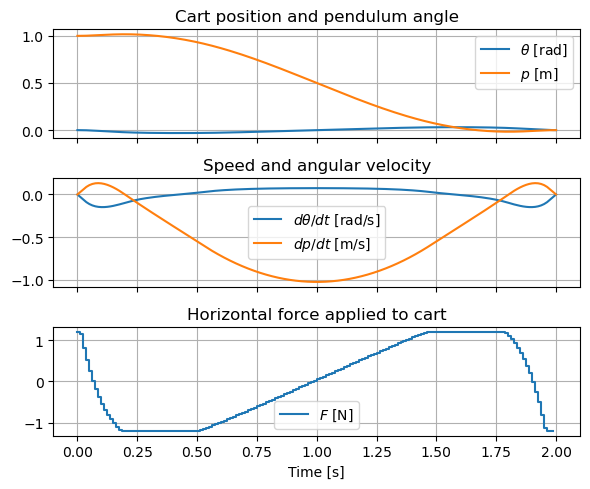

In [8]:
def make_ioplots(t, pos, theta, dpos, dtheta, u, 
                 figsize=(6, 5)):

    fig, axes = plt.subplots(3, 1, sharex=True, 
                             figsize=figsize)
    
    ax = axes[0]
    ax.plot(t, theta, label=r'$\theta$ [rad]')
    ax.plot(t, pos, label=r'$p$ [m]')
    ax.legend()
    ax.grid()
    ax.set_title('Cart position and pendulum angle')
    
    ax = axes[1]
    ax.plot(t, dtheta, label=r'$d\theta/dt$ [rad/s]')
    ax.plot(t, dpos, label=r'$dp/dt$ [m/s]')
    ax.legend()
    ax.grid()
    ax.set_title('Speed and angular velocity')
    
    ax = axes[2]
    ax.step(t[:-1], u, label=r'$F$ [N]')
    ax.set_xlabel('Time [s]')
    ax.legend()
    ax.grid()
    ax.set_title('Horizontal force applied to cart')

    plt.tight_layout()

pos_opt = sol.value(pos)
theta_opt = sol.value(theta)
dpos_opt = sol.value(dpos)
dtheta_opt = sol.value(dtheta)
u_opt = sol.value(U)
tgrid = np.linspace(0, T, N+1)

make_ioplots(tgrid, pos_opt, theta_opt, dpos_opt, dtheta_opt, u_opt)
filename = 'mpc_solution_1_ioplot.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

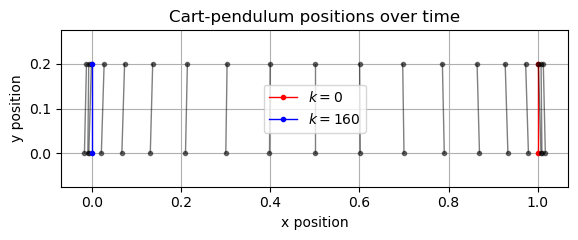

In [9]:
def pend_sequence_plot(pos, theta, k_step=8, L=L, figsize=(6, 2.5)):

    cart_pos = np.stack([pos, np.zeros_like(pos)])
    end_pos = np.stack([pos + L * np.sin(theta), L * np.cos(theta)])
    N = end_pos.shape[1]

    fig, ax = plt.subplots(figsize=figsize)

    k_values = list(range(0, N, k_step))
    labels = []
    for k in k_values:
        if k == 0:
            style, alpha, label = ('r.-', 1, f'$k = {k}$')
        elif k == k_values[-1]:
            style, alpha, label = ('b.-', 1, f'$k = {k}$')
        else:
            style, alpha, label = ('k.-', 0.5, None)
        ax.plot([cart_pos[0, k], end_pos[0, k]], 
                [cart_pos[1, k], end_pos[1, k]], 
                style, linewidth=1, alpha=alpha, label=label)

    ax.axis('equal')
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.grid()
    ax.legend()
    ax.set_title('Cart-pendulum positions over time')

    return ax

ax = pend_sequence_plot(pos_opt, theta_opt)
plt.tight_layout()
filename = 'mpc_solution_1_seq.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

## 1. Basic implementation of MPC

### 1.1 Add a strong regularization term on the cart position

$$
\DeclareMathOperator * {\minimize}{minimize}
\begin{aligned}
\minimize_{x_1,x_2,...,x_{N+1},u_1,u_2,...,u_N} \quad & \sum_{k=1}^{N}{u_k^2} + \color{red}{1000 \sum_{k=1}^{N+1}{p_k^2}} \\
\text{subject to} \quad & F(x_k,u_k) = x_{k+1}, \quad k=1, ..., N \\
                  & -3 \le x_k \le 3, \quad k=1, ..., N+1 \\
                  & -1.2 \le u_k \le 1.2, \quad k=1, ..., N \\
                  & x_1 = \left[\begin{matrix}1 & 0 & 0 & 0\end{matrix}\right]^T \\
                  & x_{N+1} = \left[\begin{matrix}0 & 0 & 0 & 0\end{matrix}\right]^T \\
\end{aligned}
$$

This will promote keeping the position of the cart close to the origin.

In [10]:
opti = casadi.Opti()

# Decision variables for states
X = opti.variable(nx, N + 1)

# Aliases for states
pos    = X[0, :]
theta  = X[1, :]
dpos   = X[2, :]
dtheta = X[3, :]

# Decision variables for control vector
U = opti.variable(N, 1)  # force [N]

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:, k], U[k]))

# Path constraints
opti.subject_to(opti.bounded(-3, pos, 3))  # Syntax -3 <= pos <= 3 not supported in Python
opti.subject_to(opti.bounded(-1.2, U, 1.2))

# Initial and terminal constraints
opti.subject_to(X[:, 0] == vertcat(1, 0, 0, 0))
opti.subject_to(X[:, -1] == vertcat(0, 0, 0, 0))

# Objective: regularization of controls + cart position
opti.minimize(sumsqr(U) + 1000 * sumsqr(pos))

opti.solver('ipopt')

# solve optimization problem
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3048
Number of nonzeros in inequality constraint Jacobian.:      321
Number of nonzeros in Lagrangian Hessian.............:     1121

Total number of variables............................:      804
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      648
Total number of inequality constraints...............:      321
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      321
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

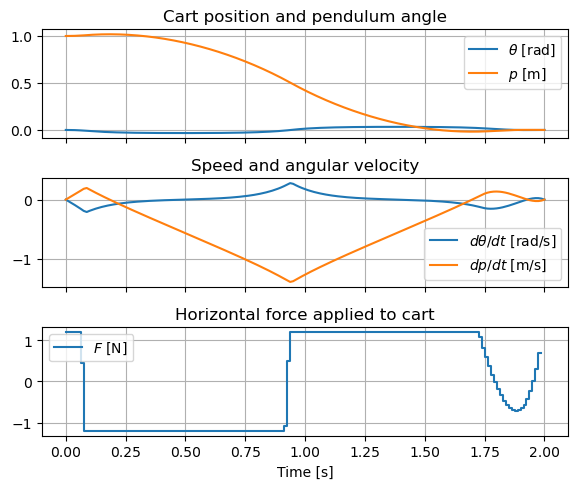

In [11]:
pos_opt = sol.value(pos)
theta_opt = sol.value(theta)
dpos_opt = sol.value(dpos)
dtheta_opt = sol.value(dtheta)
u_opt = sol.value(U)
tgrid = np.linspace(0, T, N+1)

make_ioplots(tgrid, pos_opt, theta_opt, dpos_opt, dtheta_opt, u_opt)
filename = 'mpc_solution_1_1_ioplot.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

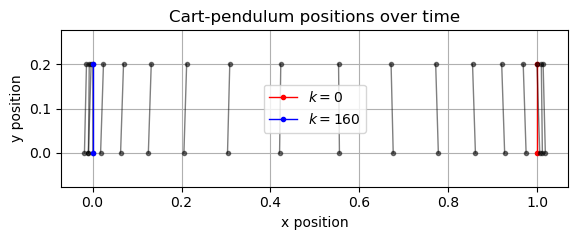

In [12]:
ax = pend_sequence_plot(pos_opt, theta_opt)
plt.tight_layout()
filename = 'mpc_solution_1_1_seq.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

### 1.2 Introduce a parameter for the initial state of the OCP

This is needed so we can repeatedly solve the MPC problem at the current state, $x_k$.

In [13]:
opti = Opti()

# Decision variables for states
X = opti.variable(nx, N + 1)

# Aliases for states
pos    = X[0, :]
theta  = X[1, :]
dpos   = X[2, :]
dtheta = X[3, :]

# Decision variables for control vector
U = opti.variable(N, 1)  # force [N]

# Parameter for initial state
x0 = opti.parameter(nx)

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:, k], U[k]))

# Path constraints
opti.subject_to(opti.bounded(-3, pos, 3))  # Syntax -3 <= pos <= 3 not supported in Python
opti.subject_to(opti.bounded(-1.2, U, 1.2))

# Initial and terminal constraints
opti.subject_to(X[:, 0] == x0)
opti.subject_to(X[:, -1] == vertcat(0, 0, 0, 0))

# Objective: regularization of controls + cart position
opti.minimize(sumsqr(U) + 1000 * sumsqr(pos))

opti.solver('ipopt')

Now we can set the parameter value and solve, then re-solve again using the following code only (don't have to recreate the problem structure as above).  The second solve and all subsequent will be fast.

In [14]:
# solve optimization problem
opti.set_value(x0, vertcat(0.5, 0, 0, 0))
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3048
Number of nonzeros in inequality constraint Jacobian.:      321
Number of nonzeros in Lagrangian Hessian.............:     1121

Total number of variables............................:      804
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      648
Total number of inequality constraints...............:      321
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      321
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.00e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

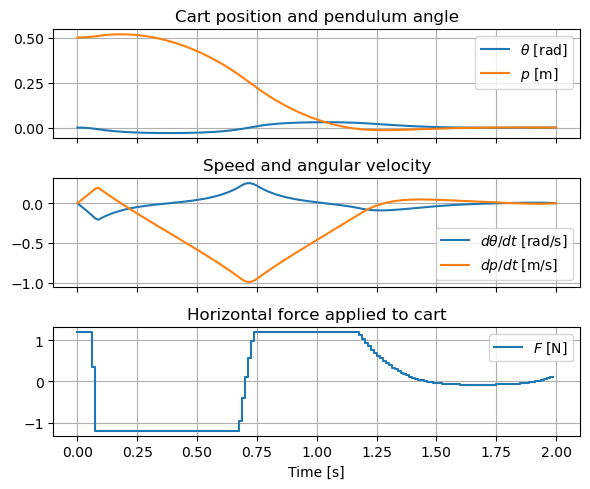

In [15]:
pos_opt = sol.value(pos)
theta_opt = sol.value(theta)
dpos_opt = sol.value(dpos)
dtheta_opt = sol.value(dtheta)
u_opt = sol.value(U)
tgrid = np.linspace(0, T, N+1)

make_ioplots(tgrid, pos_opt, theta_opt, dpos_opt, dtheta_opt, u_opt)
filename = 'mpc_solution_1_2_ioplot.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

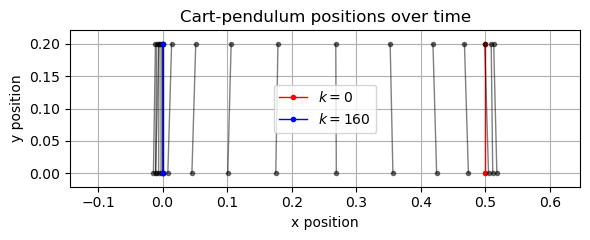

In [16]:
ax = pend_sequence_plot(pos_opt, theta_opt)
plt.tight_layout()
filename = 'mpc_solution_1_2_seq.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

### 1.3. & 1.4 Implement MPC loop for 5 sample periods and silence NLP solver output

In [17]:
Nsim = 5
xk = vertcat(0.5, 0, 0, 0)

# Silence optimizer outputs
options = {'ipopt': {"print_level": 0}}
opti.solver('ipopt', options)

x_history = DM.zeros(nx, N)
u_history = DM.zeros(1, N)

for i in range(Nsim):

    t0 = time.time()

    # Get first control action from solver solution
    uk = sol.value(U[0])
    u_history[:, i] = uk

    # Simulate the system over dt
    xk = F(xk, uk)
    x_history[:, i] = xk

    # Set the value of parameter x0 to the current x
    opti.set_value(x0, xk)

    # Solve the NLP
    sol = opti.solve()

    print(f"{i}: {time.time() - t0:.5f} seconds")

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 116.00us (  4.30us) 107.50us (  3.98us)        27
       nlp_g  |  29.46ms (  1.09ms)  29.19ms (  1.08ms)        27
  nlp_grad_f  | 218.00us (  7.79us) 202.11us (  7.22us)        28
  nlp_hess_l  | 524.70ms ( 20.18ms) 524.77ms ( 20.18ms)        26
   nlp_jac_g  | 236.19ms (  8.44ms) 236.35ms (  8.44ms)        28
       total  | 899.93ms (899.93ms) 899.62ms (899.62ms)         1
0: 0.94658 seconds
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 208.00us (  3.85us) 184.43us (  3.42us)        54
       nlp_g  |  56.84ms (  1.05ms)  56.47ms (  1.05ms)        54
    nlp_grad  |   4.36ms (  4.36ms)   4.34ms (  4.34ms)         1
  nlp_grad_f  | 362.00us (  6.46us) 329.06us (  5.88us)        56
  nlp_hess_l  |   1.01 s ( 19.51ms)   1.01 s ( 19.51ms)        52
   nlp_jac_g  | 443.01ms (  7.91ms) 443.03ms (  7.91ms)        56
       total  | 814.38ms (814.38ms) 813.75ms (813.75ms)  

Each MPC iteration takes about 0.9 seconds

## 2. Speeding up the implementation

### 2.1. Hot-starting

In [18]:
Nsim = 5
xk = vertcat(0.5, 0, 0, 0)

# Silence optimizer outputs
options = {'ipopt': {"print_level": 0}}
opti.solver('ipopt', options)

opti.set_value(x0, xk)
sol = opti.solve()

x_history = DM.zeros(nx, N)
u_history = DM.zeros(1, N)

for i in range(Nsim):

    t0 = time.time()

    # Get first control action from solver solution
    uk = sol.value(U[0])
    u_history[:, i] = uk

    # Simulate the system over dt
    xk = F(xk, uk)
    x_history[:, i] = xk

    # Set the value of parameter x0 to the current x
    opti.set_value(x0, xk)

    # Hot-start the optimization with solution from previous iteration
    opti.set_initial(opti.x, sol.value(opti.x))  # primal variables
    opti.set_initial(opti.lam_g, sol.value(opti.lam_g))  # dual variables

    # Solve the NLP
    sol = opti.solve()

    print(f"{i}: {time.time() - t0:.5f} seconds")

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  77.00us (  2.75us)  71.18us (  2.54us)        28
       nlp_g  |  27.88ms (995.75us)  27.63ms (986.85us)        28
  nlp_grad_f  | 133.00us (  4.59us) 128.58us (  4.43us)        29
  nlp_hess_l  | 497.92ms ( 18.44ms) 495.78ms ( 18.36ms)        27
   nlp_jac_g  | 212.35ms (  7.32ms) 211.54ms (  7.29ms)        29
       total  | 825.90ms (825.90ms) 822.14ms (822.14ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 116.00us (  2.76us) 113.17us (  2.69us)        42
       nlp_g  |  42.39ms (  1.01ms)  42.13ms (  1.00ms)        42
    nlp_grad  |   4.29ms (  4.29ms)   4.25ms (  4.25ms)         1
  nlp_grad_f  | 207.00us (  4.70us) 197.59us (  4.49us)        44
  nlp_hess_l  | 742.56ms ( 18.56ms) 741.08ms ( 18.53ms)        40
   nlp_jac_g  | 323.79ms (  7.36ms) 322.82ms (  7.34ms)        44
       total  | 419.63ms (419.63ms) 420.16ms (420.16ms)         1
0: 0.42530

Each MPC iteration takes around 0.5 seconds.

Interior point methods approximate the 1st order optimality conditions using a relaxed constraint (a smooth one) and then progressively increase the angle.  So the previous solution won't work well at the beginning of the next iteration.

### 2.2 Try SQP method

This is a 'text book' QP method built into CasADi (uses a sparse QP solver written by Andersson who wrote CasADi).

In [19]:
opti = Opti()

# Decision variables for states
X = opti.variable(nx, N + 1)

# Aliases for states
pos    = X[0, :]
theta  = X[1, :]
dpos   = X[2, :]
dtheta = X[3, :]

# Decision variables for control vector
U = opti.variable(N, 1)  # force [N]

# Parameter for initial state
x0 = opti.parameter(nx)

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:, k], U[k]))

# Path constraints
opti.subject_to(opti.bounded(-3, pos, 3))  # Syntax -3 <= pos <= 3 not supported in Python
opti.subject_to(opti.bounded(-1.2, U, 1.2))

# Initial and terminal constraints
opti.subject_to(X[:, 0] == x0)
opti.subject_to(X[:, -1] == vertcat(0, 0, 0, 0))

# Objective: regularization of controls + cart position
opti.minimize(sumsqr(U) + 1000 * sumsqr(pos))

In [20]:
Nsim = 5
xk = vertcat(0.5, 0, 0, 0)

options = {'qpsol': 'qrqp'}
# Silence optimizer outputs
options["qpsol_options"] = {"print_iter": False, "print_header": False}
options["print_iteration"] = False
options["print_header"] = False
options["print_status"] = False
options["print_time"] = False
opti.solver('sqpmethod', options)

opti.set_value(x0, xk)
sol = opti.solve()

x_history = DM.zeros(nx, N)
u_history = DM.zeros(1, N)

for i in range(Nsim):

    t0 = time.time()

    # Get first control action from solver solution
    uk = sol.value(U[0])
    u_history[:, i] = uk

    # Simulate the system over dt
    xk = F(xk, uk)
    x_history[:, i] = xk

    # Set the value of parameter x0 to the current x
    opti.set_value(x0, xk)

    # Hot-start the optimization with solution from previous iteration
    opti.set_initial(opti.x, sol.value(opti.x))  # primal variables
    opti.set_initial(opti.lam_g, sol.value(opti.lam_g))  # dual variables

    # Solve the NLP
    sol = opti.solve()

    print(f"{i}: {time.time() - t0:.5f} seconds")

0: 0.10318 seconds
1: 0.10638 seconds
2: 0.10161 seconds
3: 0.10131 seconds
4: 0.11121 seconds


Each MPC iteration takes about 0.1 seconds

## 2.3 Code inlining and matrix expansion

In [21]:
# CasADi function for the ODE right-hand side
xk = MX.sym('x',nx) # states: pos [m], theta [rad], dpos [m/s], dtheta [rad/s]
uk = MX.sym('u') # control force [N]

# Discrete-time system dynamics
intg_options = {'number_of_finite_elements': 1}
intg_options['simplify'] = 1

# Reference Runge-Kutta implementation
solver = 'rk'
dae = {'x': xk, 'p': uk, 'ode': f(xk, uk)}
t0 = 0
tf = dt / intg_options['number_of_finite_elements']
intg = integrator('intg', solver, dae, t0, tf, intg_options)
print(intg)
res = intg(x0=xk, p=uk)
xf = res['xf']

# Discretized system dynamics
F = Function('F', [xk, uk], [xf], ['xk', 'uk'], ['xkp1'])
F

intg:(x0[4],z0[0],p,u[0],adj_xf[],adj_zf[],adj_qf[])->(xf[4],zf[],qf[0],adj_x0[],adj_z0[],adj_p[],adj_u[]) MXFunction


Function(F:(xk[4],uk)->(xkp1[4]) MXFunction)

In [22]:
opti = Opti()

# Decision variables for states
X = opti.variable(nx, N + 1)

# Aliases for states
pos    = X[0, :]
theta  = X[1, :]
dpos   = X[2, :]
dtheta = X[3, :]

# Decision variables for control vector
U = opti.variable(N, 1)  # force [N]

# Parameter for initial state
x0 = opti.parameter(nx)

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:, k], U[k]))

# Path constraints
opti.subject_to(opti.bounded(-3, pos, 3))  # Syntax -3 <= pos <= 3 not supported in Python
opti.subject_to(opti.bounded(-1.2, U, 1.2))

# Initial and terminal constraints
opti.subject_to(X[:, 0] == x0)
opti.subject_to(X[:, -1] == vertcat(0, 0, 0, 0))

# Objective: regularization of controls + cart position
opti.minimize(sumsqr(U) + 1000 * sumsqr(pos))

In [23]:
Nsim = 5
xk = vertcat(0.5, 0, 0, 0)

options = {'qpsol': 'qrqp'}
# Silence optimizer outputs
options["qpsol_options"] = {"print_iter": False, "print_header": False}
options["print_iteration"] = False
options["print_header"] = False
options["print_status"] = False
options["print_time"] = False
opti.solver('sqpmethod', options)

opti.set_value(x0, xk)
sol = opti.solve()

x_history = DM.zeros(nx, N)
u_history = DM.zeros(1, N)

for i in range(Nsim):

    t0 = time.time()

    # Get first control action from solver solution
    uk = sol.value(U[0])
    u_history[:, i] = uk

    # Simulate the system over dt
    xk = F(xk, uk)
    x_history[:, i] = xk

    # Set the value of parameter x0 to the current x
    opti.set_value(x0, xk)

    # Hot-start the optimization with solution from previous iteration
    opti.set_initial(opti.x, sol.value(opti.x))  # primal variables
    opti.set_initial(opti.lam_g, sol.value(opti.lam_g))  # dual variables

    # Solve the NLP
    sol = opti.solve()

    print(f"{i}: {time.time() - t0:.5f} seconds")

0: 0.08771 seconds
1: 0.08708 seconds
2: 0.08942 seconds
3: 0.08706 seconds
4: 0.08595 seconds


Each MPC iteration takes about 0.07 seconds

In [24]:
xk = vertcat(0.5, 0, 0, 0)

options = {'qpsol': 'qrqp'}
# Silence optimizer outputs
options["qpsol_options"] = {"print_iter": False, "print_header": False}
options["print_iteration"] = False
options["print_header"] = False
options["print_status"] = False
options["print_time"] = False
options["expand"] = True  # makes function evaluations faster but requires more memory
opti.solver('sqpmethod', options)

opti.set_value(x0, xk)
sol = opti.solve()

Nsim = 5
x_history = DM.zeros(nx, Nsim)
u_history = DM.zeros(1, Nsim)

for i in range(Nsim):

    t0 = time.time()

    # Get first control action from solver solution
    uk = sol.value(U[0])
    u_history[:, i] = uk

    # Simulate the system over dt
    xk = F(xk, uk)
    x_history[:, i] = xk

    # Set the value of parameter x0 to the current x
    opti.set_value(x0, xk)

    # Hot-start the optimization with solution from previous iteration
    opti.set_initial(opti.x, sol.value(opti.x))  # primal variables
    opti.set_initial(opti.lam_g, sol.value(opti.lam_g))  # dual variables

    # Solve the NLP
    sol = opti.solve()

    print(f"{i}: {time.time() - t0:.5f} seconds")


0: 0.01184 seconds
1: 0.01170 seconds
2: 0.01135 seconds
3: 0.01166 seconds
4: 0.01169 seconds


Each MPC iteration takes about 0.02 seconds

### 2.4 Convert into regular CasADi function

In [25]:
opti = Opti()

# Decision variables for states
X = opti.variable(nx, N + 1)

# Aliases for states
pos    = X[0, :]
theta  = X[1, :]
dpos   = X[2, :]
dtheta = X[3, :]

# Decision variables for control vector
U = opti.variable(N, 1)  # force [N]

# Parameter for initial state
x0 = opti.parameter(nx)

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:, k], U[k]))

# Path constraints
opti.subject_to(opti.bounded(-3, pos, 3))  # Syntax -3 <= pos <= 3 not supported in Python
opti.subject_to(opti.bounded(-1.2, U, 1.2))

# Initial and terminal constraints
opti.subject_to(X[:, 0] == x0)
opti.subject_to(X[:, -1] == vertcat(0, 0, 0, 0))

# Objective: regularization of controls + cart position
opti.minimize(sumsqr(U) + 1000 * sumsqr(pos))

In [26]:
xk = vertcat(0.5, 0, 0, 0)

options = {'qpsol': 'qrqp'}
# Silence optimizer outputs
options["qpsol_options"] = {"print_iter": False, "print_header": False}
options["print_iteration"] = False
options["print_header"] = False
options["print_status"] = False
options["print_time"] = False
options["expand"] = True  # makes function evaluations faster but requires more memory
opti.solver('sqpmethod', options)

opti.set_value(x0, xk)
sol = opti.solve()

In [27]:
inputs = {'x0': x0, 'x': opti.x, 'lam_g': opti.lam_g}
outputs = {'U[0]': U[0], 'x': opti.x, 'lam_g': opti.lam_g}
options = {'allow_duplicate_io_names': 1}
mpc_step = opti.to_function('mpc_step', inputs.values(), outputs.values(), inputs.keys(), outputs.keys(), options)
mpc_step

Function(mpc_step:(x0[4],x[804],lam_g[969])->(U[0],x[804],lam_g[969]) MXFunction)

In [28]:
Nsim = 5
x_history = DM.zeros(nx, Nsim)
u_history = DM.zeros(1, Nsim)

xk = vertcat(0.5, 0, 0, 0)
opti.set_value(x0, xk)
sol = opti.solve()

uk = sol.value(U[0])
x, lam_g = sol.value(opti.x), sol.value(opti.lam_g)

for i in range(Nsim):

    t0 = time.time()

    # Save first control action from solver solution
    u_history[:, i] = uk

    # Simulate the system over dt
    xk = F(xk, uk)
    x_history[:, i] = xk

    uk, x, lam_g = mpc_step(xk, x, lam_g)

    print(f"{i}: {time.time() - t0:.5f} seconds")

0: 0.00716 seconds
1: 0.00694 seconds
2: 0.00641 seconds
3: 0.00659 seconds
4: 0.00661 seconds


Each MPC iteration takes about 0.01 seconds

Note: A further speed improvement might be possible using codegeneration. Since CasADi 3.5, you can generate C-code for `sqpmethod` and
`qrqp` QP solver routines.


## 3. Analyzing the control performance

### 3.1 Extend simulation to 200 time steps

In [29]:
Nsim = 200
x_history = DM.zeros(nx, Nsim)
u_history = DM.zeros(1, Nsim)
mpc_exec_times = np.full(Nsim, np.nan)

xk = vertcat(0.5, 0, 0, 0)
opti.set_value(x0, xk)
sol = opti.solve()
uk = sol.value(U[0])
x, lam_g = sol.value(opti.x), sol.value(opti.lam_g)

for i in range(Nsim):

    # Save first control action from solver solution
    u_history[:, i] = uk

    # Simulate the system over dt
    xk = F(xk, uk)
    x_history[:, i] = xk

    t0 = time.time()
    uk, x, lam_g = mpc_step(xk, x, lam_g)
    mpc_exec_times[i] = time.time() - t0

print(f"Avg. elapsed time per iteration: {np.mean(mpc_exec_times) * 1000:.2f} ms")

Avg. elapsed time per iteration: 4.01 ms


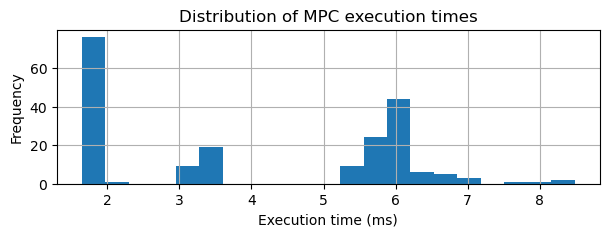

In [30]:
plt.figure(figsize=(7, 2))
plt.hist(mpc_exec_times * 1000, bins=21)
plt.xlabel('Execution time (ms)')
plt.ylabel('Frequency')
plt.title('Distribution of MPC execution times')
plt.grid()
plt.show()

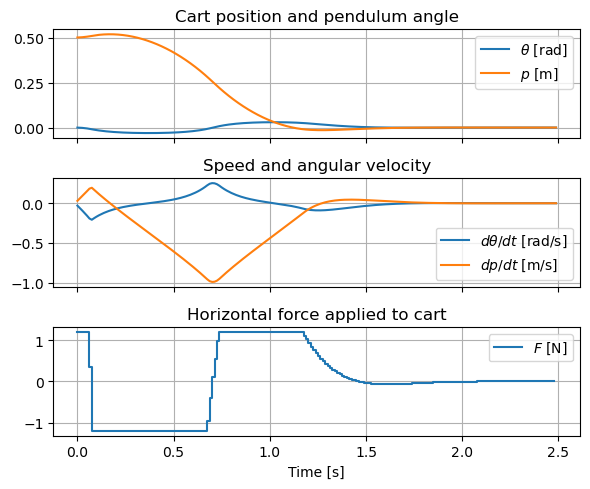

In [31]:
tgrid = dt * np.arange(Nsim)
pos = np.array(x_history[0, :]).reshape(-1)
theta = np.array(x_history[1, :]).reshape(-1)
dpos = np.array(x_history[2, :]).reshape(-1)
dtheta = np.array(x_history[3, :]).reshape(-1)
u = np.array(u_history[:-1]).reshape(-1)
make_ioplots(tgrid, pos, theta, dpos, dtheta, u)
filename = 'mpc_solution_3_1_ioplot.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [32]:
# Root-mean-squared tracking error in system states
x_rmse = np.sqrt(np.mean(np.array(x_history) ** 2))
x_rmse

0.22939975412928276

The system regulated towards $[0, 0, 0, 0]^T$ as mandated by the terminal constraint, which is at the end of the prediction horizon.

Time at step $k = 161$ (the end of the prediction horizon at $t = 0$)

In [33]:
k = 161
t = k * dt
t

2.0125

In [34]:
xk = np.array(x_history[:, k]).reshape(-1)
xk

array([ 0.00028846, -0.00029674, -0.00063332,  0.00195251])

The reason it does not actually reach zero at $k = 161$ is that we only implement the first control action of the solver's optimal solution at $t = 0$.  After that, the prediction horizon is shifted ahead in time and so the terminal constraint is also further ahead.

### 3.2 Add a random disturbance to the system

In [35]:
Nsim = 400

# Random process disturbance
k_noise_start = Nsim // 2
W = DM(np.stack([
    np.zeros(Nsim), 
    np.zeros(Nsim), 
    np.zeros(Nsim), 
    np.concatenate([np.zeros(k_noise_start), 0.01 * np.random.rand(Nsim - k_noise_start)])
]))
assert W.shape == (4, Nsim)

x_history = DM.zeros(nx, Nsim)
u_history = DM.zeros(1, Nsim)
mpc_exec_times = np.full(Nsim, np.nan)

xk = vertcat(0.5, 0, 0, 0)
opti.set_value(x0, xk)
sol = opti.solve()
uk = sol.value(U[0])
x, lam_g = sol.value(opti.x), sol.value(opti.lam_g)

for i in range(Nsim):

    # Save first control action from solver solution
    u_history[:, i] = uk

    # Simulate the system over dt
    xk = F(xk, uk) + W[:, i]
    x_history[:, i] = xk

    t0 = time.time()
    uk, x, lam_g = mpc_step(xk, x, lam_g)
    mpc_exec_times[i] = time.time() - t0

print(f"Avg. elapsed time per iteration: {np.mean(mpc_exec_times) * 1000:.2f} ms")

Avg. elapsed time per iteration: 3.61 ms


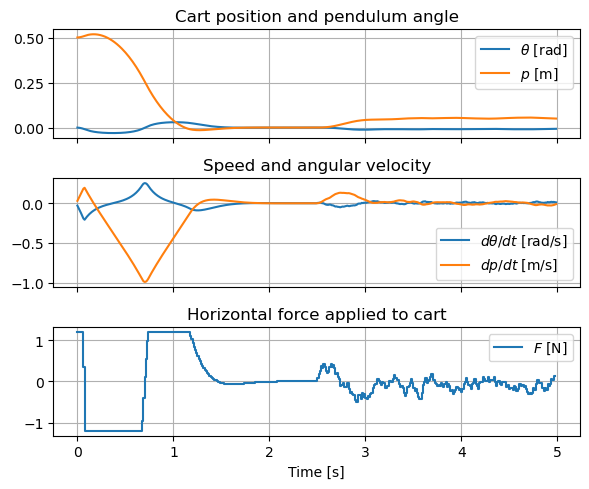

In [36]:
tgrid = dt * np.arange(Nsim)
pos = np.array(x_history[0, :]).reshape(-1)
theta = np.array(x_history[1, :]).reshape(-1)
dpos = np.array(x_history[2, :]).reshape(-1)
dtheta = np.array(x_history[3, :]).reshape(-1)
u = np.array(u_history[:-1]).reshape(-1)
make_ioplots(tgrid, pos, theta, dpos, dtheta, u)
filename = 'mpc_solution_3_2_ioplot.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [37]:
# Root-mean-squared tracking error in system states
x_rmse = np.sqrt(np.mean(np.array(x_history) ** 2))
x_rmse

0.16393792641606614

When the random disturbance is applied to the states of the simulated system, the MPC is unable to get the system to the $[0, 0, 0, 0]^T$ state.  If you look at the position $p$ in the plot above, there is a steady-state error (or offset).

A well-tuned PID controller would be able to compensate for the steady-state error because it has an integrator action.

To achieve offset-free control with MPC you need to design the system model (augment the state-space model) to allow for the disturbance and use an estimator to estimate it in real time.